In [1]:
!hostname

gnode014.cluster


In [2]:
!nvidia-smi

Wed Mar 27 18:33:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               Off | 00000000:A8:00.0 Off |                    0 |
| N/A   26C    P0              47W / 350W |      4MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
seed = 6666
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

200.0
(1000, 400) (1000, 400)
(400, 400) (400, 400) (400, 400)
(400, 400, 2)
CPU times: user 1.87 s, sys: 2.89 ms, total: 1.87 s
Wall time: 1.89 s


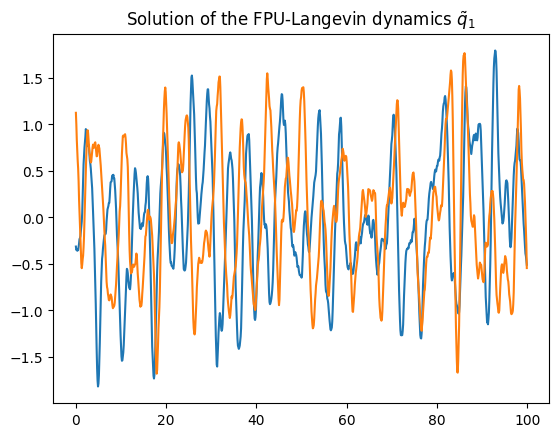

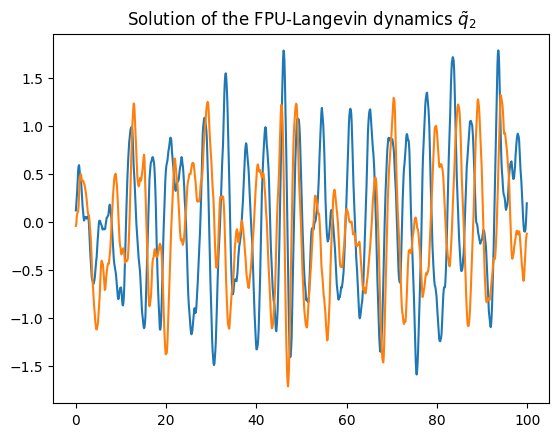

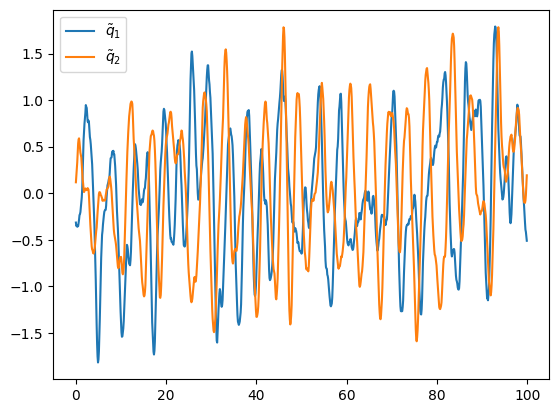

In [8]:
%%time

#### Generating SINN training data by solving SDE (Langevin dynamics)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad


def V_FPU(x,U0,x0):
    v=U0/x0**4*x**3+U0/x0**2*x      # FPU potential 
    return v


#### Parameters 
gamma1 = 1                             # coupling constant 
gamma2 = .5                            # coupling constant
beta = 1                               # Inverse temperature, i.e. T=1/beta
dt = 0.01                              # Step-size of the SDE solver 
delta_t = 0.1                          # Step-size of the temporally coarse-grained path
batch = 400                           # Batch size 
sec_length = 400                       # Length of the input sequence 
U0 = 1                                 # FPU parameter, depth of the well 
x0 = 1                                 # FPU parameter, position of the basin 
rho = 0.00                             # Correlation of q1 and q2 

#### SDE solver (EM scheme) 
Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
q1_store = np.zeros([t_store.size+1,batch])
q2_store = np.zeros([t_store.size+1,batch])
# q_store = np.zeros([t_store.size+1,batch])
p1=np.zeros((2,batch))
p2=np.zeros((2,batch))
q1=np.zeros((2,batch))
q2=np.zeros((2,batch))

# solve SDE
j=1
for i in range(1,length):
     q1[1,:] = q1[0,:] + p1[0,:]*dt
     p1[1,:] = p1[0,:] + (-V_FPU(q1[0,:],U0,x0)-gamma1*p1[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma1/beta)
     q2[1,:] = q2[0,:] + p2[0,:]*dt
     p2[1,:] = p2[0,:] + (-V_FPU(q2[0,:],U0,x0)-gamma2*p2[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma2/beta)
     if i % gap ==0:            
            q1_store[j,:]=q1[1,:]
            q2_store[j,:]=rho*q1[1,:]+np.sqrt(1-rho**2)*q2[1,:]
            j=j+1
     p1[0,:]=p1[1,:]
     q1[0,:]=q1[1,:]
     p2[0,:]=p2[1,:]
     q2[0,:]=q2[1,:]

Toss=int(t_store.size/2)         
q1_store=q1_store[Toss:-1,:]         
q2_store=q2_store[Toss:-1,:]    
print(q1_store.shape,q2_store.shape)




plt.figure(0)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,i])
plt.title(r"Solution of the FPU-Langevin dynamics $\tilde{q}_1$")
# plt.savefig("figs/FPU_dt016.pdf", dpi=150)

plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,i])
plt.title(r"Solution of the FPU-Langevin dynamics $\tilde{q}_2$")

plt.figure(2)
plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0], label=r'$\tilde{q}_1$')
plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,0], label=r'$\tilde{q}_2$')
# plt.title("Solution of the FPU-Langevin dynamics")
plt.legend()
# Construct the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
Traj_q1=q1_store[0:sec_length,:]
Traj_q2=q2_store[0:sec_length,:]
print(ini.shape, Traj_q1.shape, Traj_q2.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj_q1
Traj[:,:,1] = Traj_q2
T=np.arange(len(Traj_q1[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(Traj.shape)

In [9]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


(array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3')])

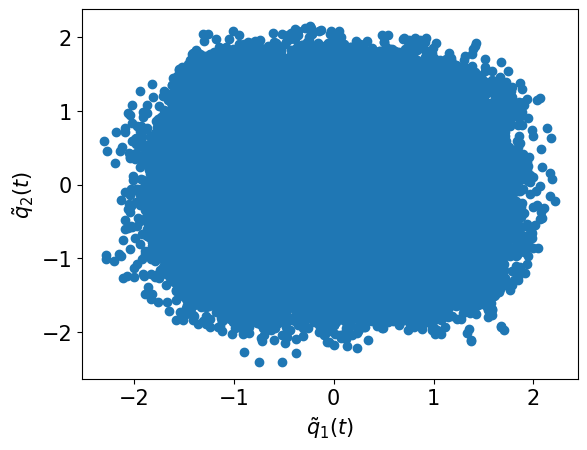

In [10]:
plt.scatter(Traj[:,:,0], Traj[:,:,1])
plt.xlabel(r'$\tilde{q}_1(t)$',fontsize=15)
plt.ylabel(r'$\tilde{q}_2(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [11]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical1 = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2 = make_loss('pdf2', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2D = make_loss('pdf2D', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


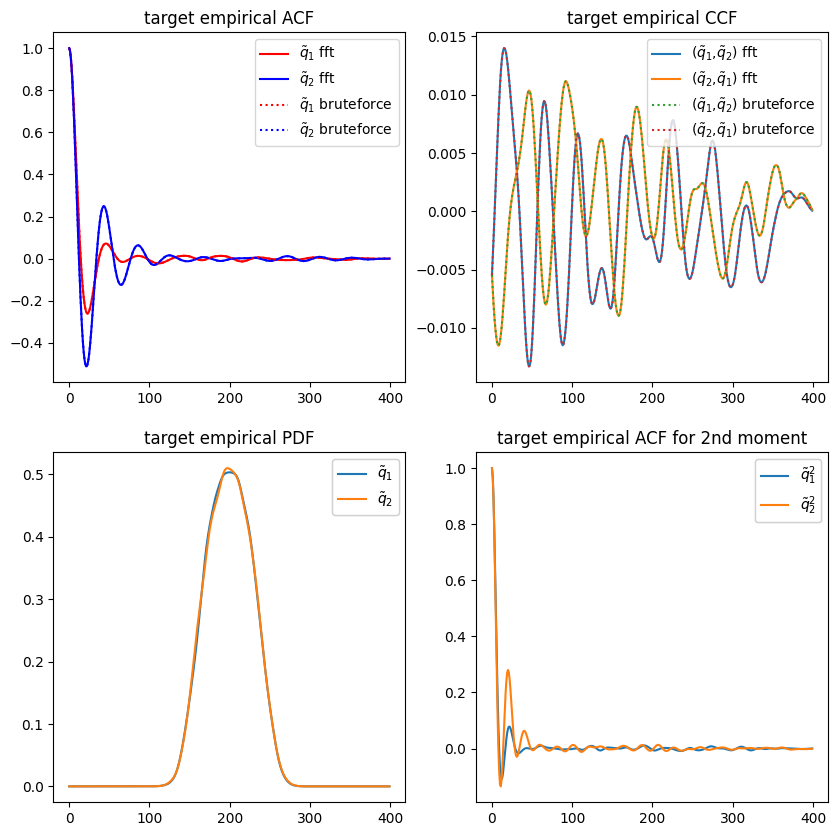

In [12]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$\tilde{q}_1$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,-1],'b', label=r'$\tilde{q}_2$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$\tilde{q}_1$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$\tilde{q}_2$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,0], label=r'($\tilde{q}_1$,$\tilde{q}_2$) fft')
axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1], label=r'($\tilde{q}_2$,$\tilde{q}_1$) fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,0],':',label=r'($\tilde{q}_1$,$\tilde{q}_2$) bruteforce')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1],':',label=r'($\tilde{q}_2$,$\tilde{q}_1$) bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical1._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$\tilde{q}_1$', r'$\tilde{q}_2$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$\tilde{q}_1^2$', r'$\tilde{q}_2^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

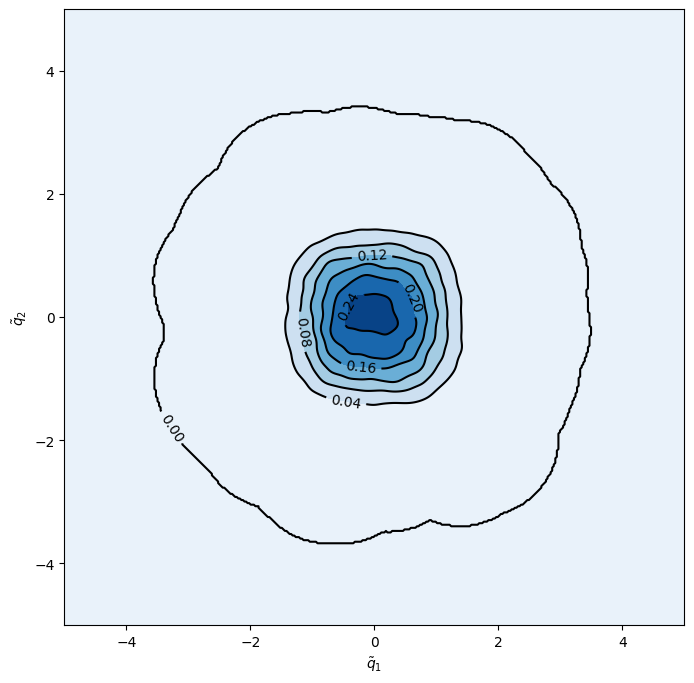

In [13]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5

xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Contourf plot
cfset = ax.contourf(xx, yy, loss_pdf_empirical2D._target.cpu(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot

# Contour plot
cset = ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(r'$\tilde{q}_1$')
ax.set_ylabel(r'$\tilde{q}_2$')

plt.show()

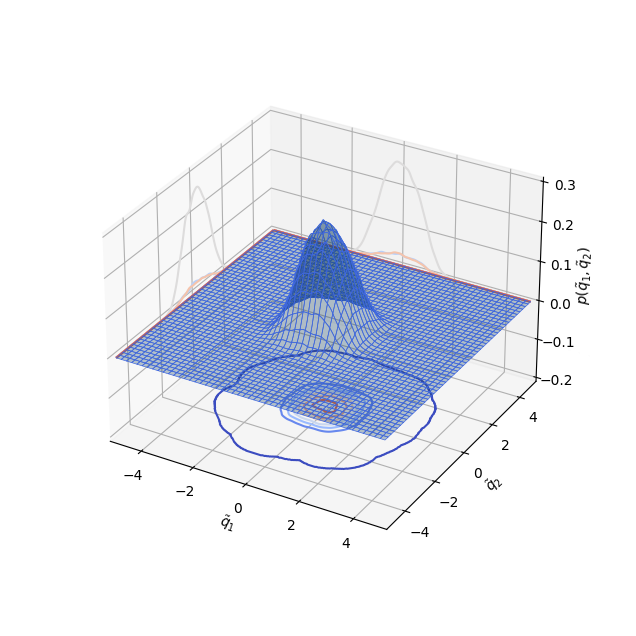

In [14]:
from mpl_toolkits.mplot3d import axes3d

ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
# fig = plt.figure()
# X, Y, Z = axes3d.get_test_data(0.05)

# Plot the 3D surface
ax.plot_surface(xx, yy, loss_pdf_empirical2D._target.cpu(), edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph.
ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), zdir='z', offset=-0.2, cmap='coolwarm')
ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), zdir='x', offset=-5, cmap='coolwarm')
ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), zdir='y', offset=5, cmap='coolwarm')

ax.set(xlim=(-5, 5), ylim=(-5, 5), zlim=(-0.2, 0.3),xlabel=r'$\tilde{q}_1$', ylabel=r'$\tilde{q}_2$', zlabel=r'$p(\tilde{q}_1,\tilde{q}_2)$')
ax.set_box_aspect(aspect=None, zoom=0.8)
plt.show()

Text(0.5, 1.0, 'target empirical PDF')

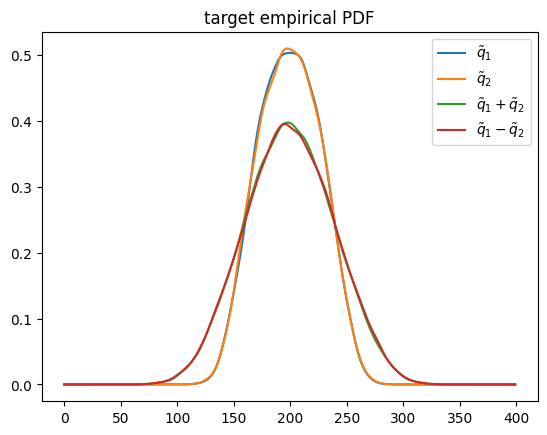

In [15]:
x_grid=-np.linspace(-5,5,num=sec_length)
plt.plot(loss_pdf_empirical1._target.cpu()[...,0],label=r'$\tilde{q}_1$')
plt.plot(loss_pdf_empirical1._target.cpu()[...,1],label=r'$\tilde{q}_2$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,0],label=r'$\tilde{q}_1+\tilde{q}_2$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,1],label=r'$\tilde{q}_1-\tilde{q}_2$')
# plt.plot(loss_pdf_empirical2._target.cpu()[...,2],label=r'$\tilde{q}_1+2*\tilde{q}_2$')
# plt.plot(loss_pdf_empirical2._target.cpu()[...,3],label=r'$\tilde{q}_1-2*\tilde{q}_2$')
# plt.plot(loss_pdf_empirical2._target.cpu()[...,4],label=r'$2*\tilde{q}_1+\tilde{q}_2$')
# plt.plot(loss_pdf_empirical2._target.cpu()[...,5],label=r'$2*\tilde{q}_1-\tilde{q}_2$')
plt.legend()
plt.title('target empirical PDF')

In [16]:
class Model:
    def __init__(self, net):

        self.x_acf_s = None
        self.x_ccf_s = None
        self.x_pdf_s = None
        self.x_pdf2_s = None
        self.x_acf2_s = None
        self.s_collect = []

        self.net = net

        self.T_error=[]
        self.V_error=[]
        self.T_ccf=[]
        self.V_ccf=[]
        self.T_pdf=[]
        self.V_pdf=[]
        self.T_pdf2=[]
        self.V_pdf2=[]
        self.T_acf=[]
        self.V_acf=[]
        self.T_acf2=[]
        self.V_acf2=[]
        self.Step=[]
        self.iter = 0

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        loss = torch.reciprocal(2. * self.x_acf_s ** 2) * loss_acf.detach()      \
               + torch.reciprocal(2. * self.x_ccf_s ** 2) * loss_ccf.detach()    \
               + torch.reciprocal(2. * self.x_pdf_s ** 2) * loss_pdf.detach()    \
               + torch.reciprocal(2. * self.x_pdf2_s ** 2) * loss_pdf2.detach()  \
               + torch.reciprocal(2. * self.x_acf2_s ** 2) * loss_acf2.detach()  \
               + torch.log(self.x_acf_s * self.x_ccf_s * self.x_pdf_s * self.x_pdf2_s * self.x_acf2_s)
        return loss

    def true_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        return torch.reciprocal(2. * self.x_acf_s.detach() ** 2) * loss_acf + torch.reciprocal(2. * self.x_ccf_s.detach() ** 2) * loss_ccf + torch.reciprocal(2. * self.x_pdf_s.detach() ** 2) * loss_pdf + torch.reciprocal(2. * self.x_pdf2_s.detach() ** 2) * loss_pdf2 + torch.reciprocal(2. * self.x_acf2_s.detach() ** 2) * loss_acf2

    def run_baseline(self):
        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        for step in range(20000):
            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val)+ loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <=0.0003 and loss_val <=0.0003:
                break

        if loss > 0.0003 and loss_val > 0.0003:
            print ('Training failed')
        print('Training finished')



    def run_AW(self):
        self.x_acf_s = nn.Parameter(self.x_acf_s, requires_grad=True)
        self.x_ccf_s = nn.Parameter(self.x_ccf_s, requires_grad=True)
        self.x_pdf_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_pdf2_s = nn.Parameter(self.x_pdf2_s, requires_grad=True)
        self.x_acf2_s = nn.Parameter(self.x_acf2_s, requires_grad=True)


        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        optimizer_adam_weight = optim.Adam([self.x_acf_s] + [self.x_ccf_s] + [self.x_pdf_s] + [self.x_pdf2_s] + [self.x_acf2_s],
                                                     lr=1e-3)

        for step in range(20000):
            self.s_collect.append([self.iter, self.x_acf_s.item(), self.x_ccf_s.item(), self.x_pdf_s.item(), self.x_pdf2_s.item(), self.x_acf2_s.item()])

            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val) + loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <=0.0003 and loss_val <=0.0003:
                break
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam_weight.step()
            
        if loss > 0.0003 and loss_val > 0.0003:
            print ('Training failed')
        print('Training finished')


    def train(self):
        self.x_acf_s = torch.tensor(2.).float()
        self.x_ccf_s = torch.tensor(2.).float()
        self.x_pdf_s = torch.tensor(2.).float()
        self.x_pdf2_s = torch.tensor(2.).float()
        self.x_acf2_s = torch.tensor(2.).float()
        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AW()
        elapsed = time.time() - start_time
        print('Training time: %.2f' % elapsed)

In [17]:
### Defining SINN model
net = SINN(1, 10, 2, 2).to(device)

In [18]:
AWmodel_1input_1pair = Model(net=net)

In [19]:
model_type = 1

In [20]:
AWmodel_1input_1pair.train()

[0]-th step loss: 0.5224, 0.5213, acf: 0.01162, ccf: 0.00488, pdf: 0.24582, pdf2: 0.25607, acf2: 0.00295
[50]-th step loss: 0.2345, 0.2219, acf: 0.00719, ccf: 0.00957, pdf: 0.12161, pdf2: 0.08225, acf2: 0.00132
[100]-th step loss: 0.0574, 0.0563, acf: 0.00758, ccf: 0.01535, pdf: 0.01548, pdf2: 0.01625, acf2: 0.00162
[150]-th step loss: 0.0445, 0.0440, acf: 0.00643, ccf: 0.01283, pdf: 0.01152, pdf2: 0.01199, acf2: 0.00118
[200]-th step loss: 0.0370, 0.0370, acf: 0.00617, ccf: 0.01106, pdf: 0.00904, pdf2: 0.00942, acf2: 0.00128
[250]-th step loss: 0.0296, 0.0294, acf: 0.00501, ccf: 0.00998, pdf: 0.00669, pdf2: 0.00641, acf2: 0.00133
[300]-th step loss: 0.0218, 0.0220, acf: 0.00360, ccf: 0.00998, pdf: 0.00387, pdf2: 0.00333, acf2: 0.00126
[350]-th step loss: 0.0179, 0.0180, acf: 0.00415, ccf: 0.00899, pdf: 0.00198, pdf2: 0.00184, acf2: 0.00104
[400]-th step loss: 0.0147, 0.0146, acf: 0.00366, ccf: 0.00804, pdf: 0.00087, pdf2: 0.00110, acf2: 0.00090
[450]-th step loss: 0.0096, 0.0094, acf:

[3850]-th step loss: 0.0119, 0.0121, acf: 0.00489, ccf: 0.00622, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00095
[3900]-th step loss: 0.0121, 0.0122, acf: 0.00491, ccf: 0.00627, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00099
[3950]-th step loss: 0.0120, 0.0123, acf: 0.00501, ccf: 0.00622, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00103
[4000]-th step loss: 0.0119, 0.0121, acf: 0.00497, ccf: 0.00612, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00099
[4050]-th step loss: 0.0116, 0.0119, acf: 0.00494, ccf: 0.00600, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00094
[4100]-th step loss: 0.0123, 0.0120, acf: 0.00486, ccf: 0.00622, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00094
[4150]-th step loss: 0.0118, 0.0121, acf: 0.00494, ccf: 0.00618, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00097
[4200]-th step loss: 0.0124, 0.0121, acf: 0.00484, ccf: 0.00627, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00093
[4250]-th step loss: 0.0119, 0.0121, acf: 0.00492, ccf: 0.00618, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00094
[4300]-th step loss: 0.0116,

[7650]-th step loss: 0.0100, 0.0102, acf: 0.00506, ccf: 0.00452, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00058
[7700]-th step loss: 0.0102, 0.0103, acf: 0.00521, ccf: 0.00450, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00056
[7750]-th step loss: 0.0102, 0.0104, acf: 0.00527, ccf: 0.00454, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00058
[7800]-th step loss: 0.0099, 0.0102, acf: 0.00530, ccf: 0.00434, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00056
[7850]-th step loss: 0.0100, 0.0100, acf: 0.00504, ccf: 0.00435, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00055
[7900]-th step loss: 0.0101, 0.0102, acf: 0.00520, ccf: 0.00436, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00056
[7950]-th step loss: 0.0097, 0.0101, acf: 0.00530, ccf: 0.00427, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00055
[8000]-th step loss: 0.0097, 0.0099, acf: 0.00519, ccf: 0.00419, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00052
[8050]-th step loss: 0.0098, 0.0102, acf: 0.00529, ccf: 0.00430, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00056
[8100]-th step loss: 0.0099,

[11450]-th step loss: 0.0068, 0.0067, acf: 0.00623, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00036
[11500]-th step loss: 0.0063, 0.0066, acf: 0.00615, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00036
[11550]-th step loss: 0.0064, 0.0065, acf: 0.00610, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00033
[11600]-th step loss: 0.0066, 0.0066, acf: 0.00619, ccf: 0.00004, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00037
[11650]-th step loss: 0.0069, 0.0067, acf: 0.00631, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00038
[11700]-th step loss: 0.0068, 0.0065, acf: 0.00609, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00034
[11750]-th step loss: 0.0070, 0.0067, acf: 0.00624, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00036
[11800]-th step loss: 0.0068, 0.0066, acf: 0.00615, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00035
[11850]-th step loss: 0.0069, 0.0067, acf: 0.00627, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00036
[11900]-th step los

[15250]-th step loss: 0.0060, 0.0059, acf: 0.00559, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00026
[15300]-th step loss: 0.0063, 0.0060, acf: 0.00569, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00027
[15350]-th step loss: 0.0060, 0.0059, acf: 0.00553, ccf: 0.00004, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00027
[15400]-th step loss: 0.0062, 0.0061, acf: 0.00577, ccf: 0.00003, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00028
[15450]-th step loss: 0.0065, 0.0062, acf: 0.00586, ccf: 0.00004, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00027
[15500]-th step loss: 0.0063, 0.0061, acf: 0.00575, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00027
[15550]-th step loss: 0.0063, 0.0060, acf: 0.00570, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00027
[15600]-th step loss: 0.0061, 0.0060, acf: 0.00570, ccf: 0.00004, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00027
[15650]-th step loss: 0.0061, 0.0060, acf: 0.00563, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00027
[15700]-th step los

[19050]-th step loss: 0.0054, 0.0053, acf: 0.00508, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00021
[19100]-th step loss: 0.0058, 0.0056, acf: 0.00535, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00020
[19150]-th step loss: 0.0057, 0.0055, acf: 0.00521, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00020
[19200]-th step loss: 0.0052, 0.0052, acf: 0.00492, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00020
[19250]-th step loss: 0.0058, 0.0055, acf: 0.00523, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00019
[19300]-th step loss: 0.0056, 0.0054, acf: 0.00512, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00019
[19350]-th step loss: 0.0057, 0.0054, acf: 0.00509, ccf: 0.00004, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00019
[19400]-th step loss: 0.0055, 0.0053, acf: 0.00509, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00019
[19450]-th step loss: 0.0056, 0.0052, acf: 0.00500, ccf: 0.00004, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00019
[19500]-th step los

In [21]:
def draw_loss(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'r',label='Training error')
    plt.plot(model.Step, model.V_error,'b--',label='Validation error')
#     plt.loglog(model.Step, model.T_error,'r',label='Training error')
#     plt.loglog(model.Step, model.V_error,'b--',label='Validation error')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [22]:
def draw_errors(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot for loss functions w/o coeff",fontsize=15)
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'k',label='Training error')
    plt.plot(model.Step, model.V_error,'k--')
    plt.plot(model.Step, model.T_acf,'r',label='acf error')
    plt.plot(model.Step, model.V_acf,'r--')
    plt.plot(model.Step, model.T_ccf,'b',label='ccf error')
    plt.plot(model.Step, model.V_ccf,'b--')
    plt.plot(model.Step, model.T_pdf,'y',label='pdf error')
    plt.plot(model.Step, model.V_pdf,'y--')
    plt.plot(model.Step, model.T_pdf2,'m',label='pdf2 error')
    plt.plot(model.Step, model.V_pdf2,'m--')
    plt.plot(model.Step, model.T_acf2,'g',label='acf2 error')
    plt.plot(model.Step, model.V_acf2,'g--')
    
#     plt.loglog(model.Step, model.T_error,'k',label='Training error')
#     plt.loglog(model.Step, model.V_error,'k--')
#     plt.loglog(model.Step, model.T_acf,'r',label='acf error')
#     plt.loglog(model.Step, model.V_acf,'r--')
#     plt.loglog(model.Step, model.T_ccf,'b',label='ccf error')
#     plt.loglog(model.Step, model.V_ccf,'b--')
#     plt.loglog(model.Step, model.T_pdf,'y',label='pdf error')
#     plt.loglog(model.Step, model.V_pdf,'y--')
#     plt.loglog(model.Step, model.T_pdf2,'m',label='pdf2 error')
#     plt.loglog(model.Step, model.V_pdf2,'m--')
#     plt.loglog(model.Step, model.T_acf2,'g',label='acf2 error')
#     plt.loglog(model.Step, model.V_acf2,'g--')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [23]:
def draw_adaptive_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
#     plt.yscale('log')
    plt.plot(s_collect[:, 0], s_collect[:, 1], 'r-', label=r'$\epsilon_{acf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 2], 'b-', label='$\epsilon_{ccf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 3], 'y-', label='$\epsilon_{pdf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 4], 'm-', label='$\epsilon_{pdf2}$')
    plt.plot(s_collect[:, 0], s_collect[:, 5], 'g-', label='$\epsilon_{acf2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$s$')
#     plt.xscale('log')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

In [24]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 1]**2), 'r-', label=r'$\frac{1}{2\epsilon_{acf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 2]**2), 'b-', label=r'$\frac{1}{2\epsilon_{ccf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 3]**2), 'y-', label=r'$\frac{1}{2\epsilon_{pdf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 4]**2), 'm-', label=r'$\frac{1}{2\epsilon_{pdf2}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 5]**2), 'g-', label=r'$\frac{1}{2\epsilon_{acf2}^2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\omega$')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

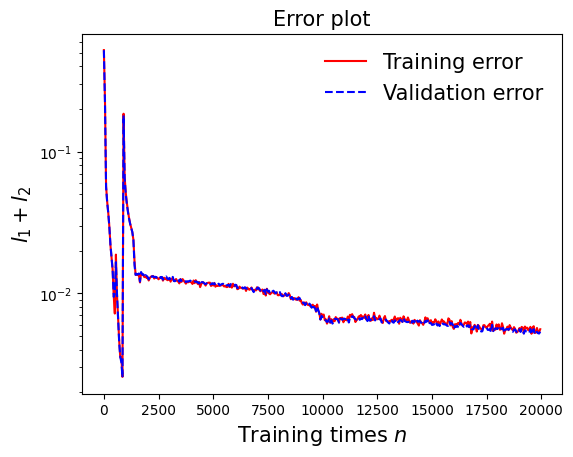

In [25]:
draw_loss(AWmodel_1input_1pair)

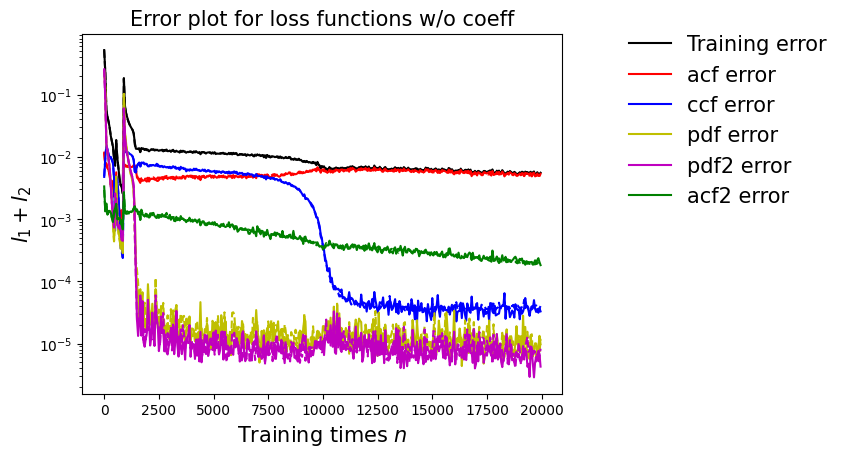

In [26]:
draw_errors(AWmodel_1input_1pair)

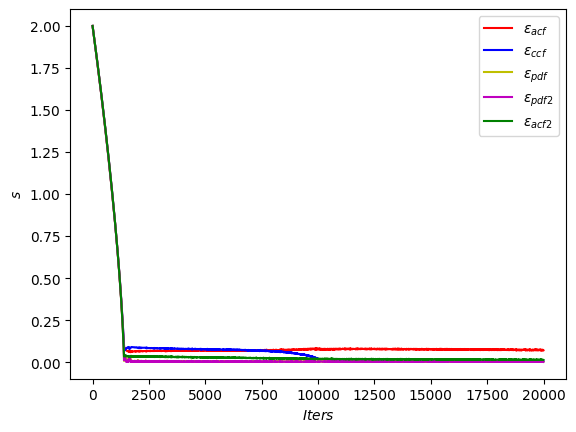

In [27]:
draw_adaptive_w(AWmodel_1input_1pair)

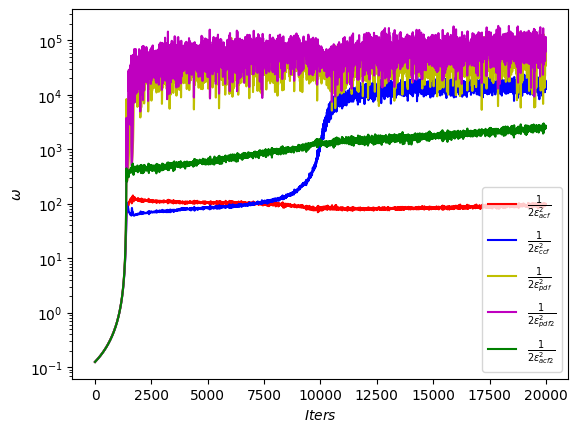

In [28]:
draw_epoch_w(AWmodel_1input_1pair)

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [29]:
def test1(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$\tilde{q}_1(t)$ and $\tilde{q}_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$ and $q_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

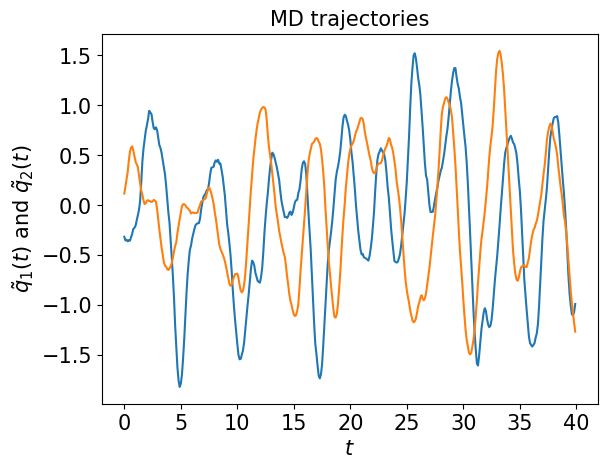

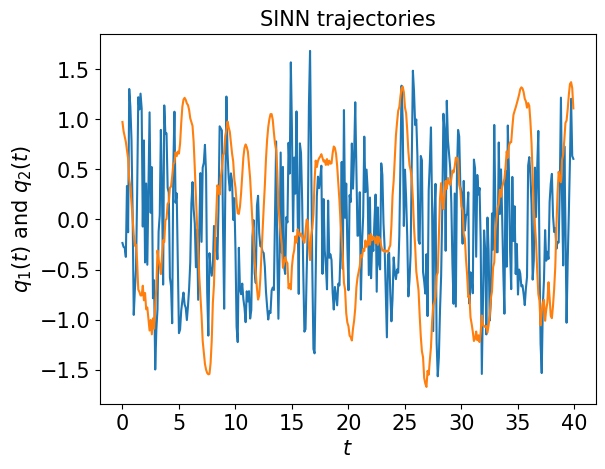

In [30]:
test1(AWmodel_1input_1pair)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [31]:
def test2(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t2[:,:],'r')        # correlation function of the target 
    plt.plot(T, corr_p2[:,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.ylim(-0.05,0.05)

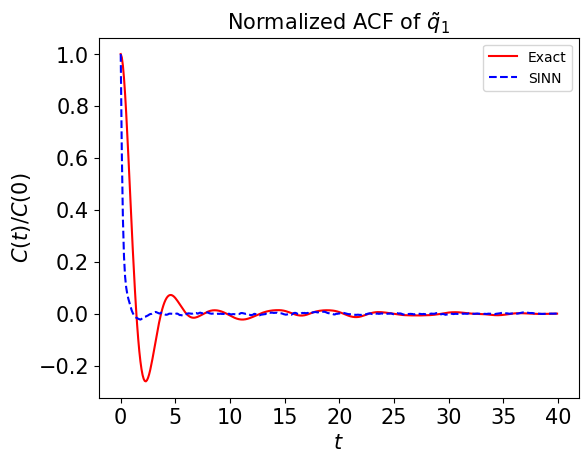

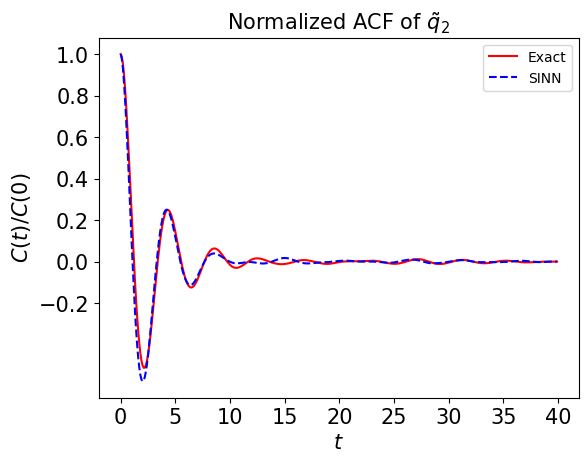

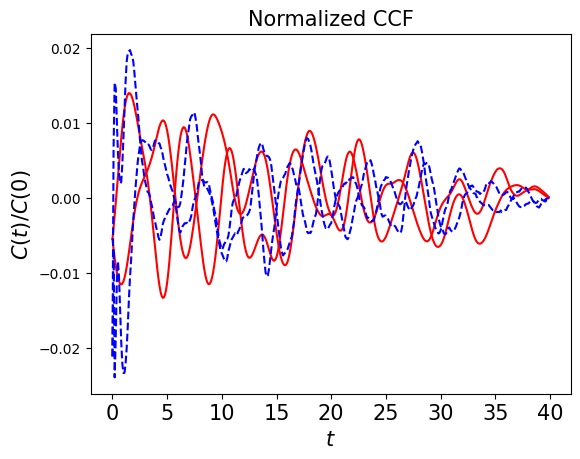

In [32]:
test2(AWmodel_1input_1pair)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [33]:
def test3(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 400, None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    rho_data2 =  StatLoss.gauss_kde6(target, -5, 5, 400, None).cpu()
    rho_prediction2 = StatLoss.gauss_kde6(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()


    x=np.linspace(-5, 5, 400)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $\tilde{q}_1$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $\tilde{q}_2$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $\tilde{q}_1$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $\tilde{q}_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,0],label=r'Exact PDF of $\tilde{q}_1+\tilde{q}_2$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,1],label=r'Exact PDF of $\tilde{q}_2-\tilde{q}_2$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,0], ':',label=r'PDF of the output $\tilde{q}_1+\tilde{q}_2$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,1], ':',label=r'PDF of the output $\tilde{q}_1-\tilde{q}_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
#     fig = plt.figure(2)
#     ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
#     plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
#     plt.plot(x, rho_data2.numpy()[...,2],label=r'Exact PDF of $\tilde{q}_1+2\tilde{q}_2$')    # target PDF
#     plt.plot(x, rho_data2.numpy()[...,3],label=r'Exact PDF of $\tilde{q}_2-2\tilde{q}_2$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
#     plt.plot(x, rho_prediction2.numpy()[...,2], ':',label=r'PDF of the output $\tilde{q}_1+2\tilde{q}_2$')  # PDF after the training 
#     plt.plot(x, rho_prediction2.numpy()[...,3], ':',label=r'PDF of the output $\tilde{q}_1-2\tilde{q}_2$')  # PDF after the training 
#     plt.xlim(-5,5)
#     plt.ylim(0,0.6)
#     plt.xlabel(r'$x$',fontsize=15)
#     plt.ylabel(r'$\rho(x)$',fontsize=15)
#     plt.legend(frameon=False,fontsize=10)
#     plt.xticks(fontsize=15)
#     plt.yticks(fontsize=15)
    
#     fig = plt.figure(3)
#     ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
#     plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
#     plt.plot(x, rho_data2.numpy()[...,4],label=r'Exact PDF of $2\tilde{q}_1+\tilde{q}_2$')    # target PDF
#     plt.plot(x, rho_data2.numpy()[...,5],label=r'Exact PDF of $2\tilde{q}_2-\tilde{q}_2$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
#     plt.plot(x, rho_prediction2.numpy()[...,4], ':',label=r'PDF of the output $2\tilde{q}_1+\tilde{q}_2$')  # PDF after the training 
#     plt.plot(x, rho_prediction2.numpy()[...,5], ':',label=r'PDF of the output $2\tilde{q}_1-\tilde{q}_2$')  # PDF after the training 
#     plt.xlim(-5,5)
#     plt.ylim(0,0.6)
#     plt.xlabel(r'$x$',fontsize=15)
#     plt.ylabel(r'$\rho(x)$',fontsize=15)
#     plt.legend(frameon=False,fontsize=10)
#     plt.xticks(fontsize=15)
#     plt.yticks(fontsize=15)

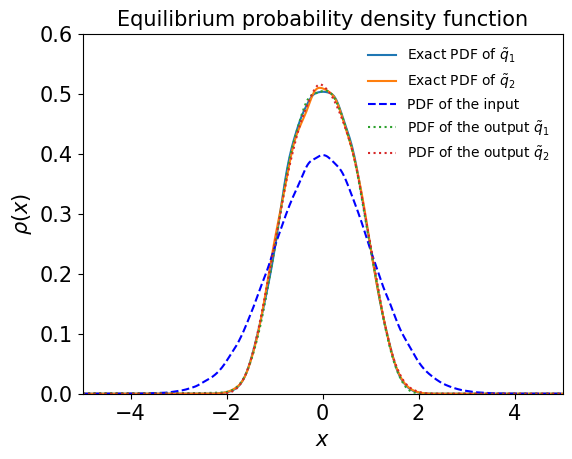

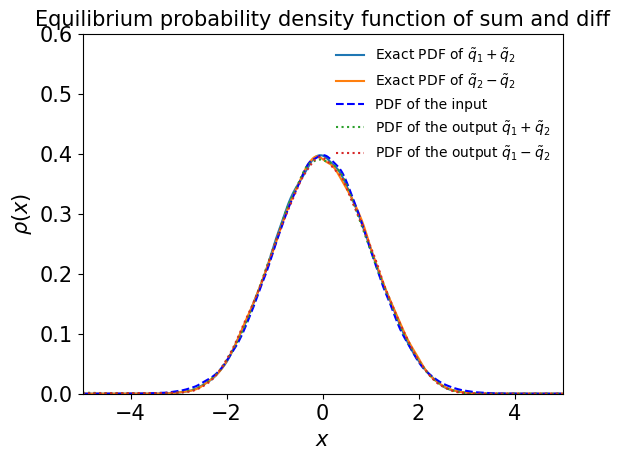

In [34]:
test3(AWmodel_1input_1pair)

## Test 4: Comparing the higher-order ACF

In [35]:
def test4(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_1^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_2^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    
    
    
    
    
    


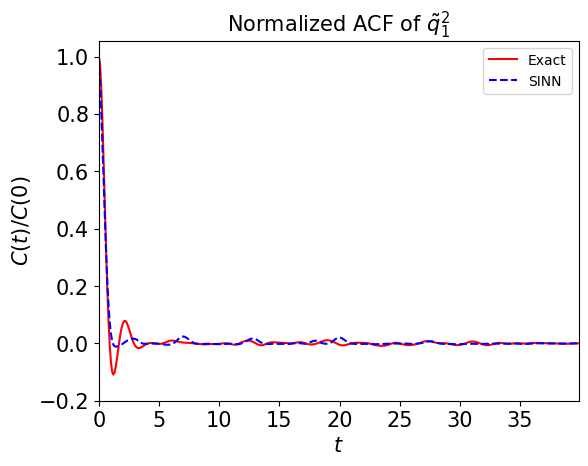

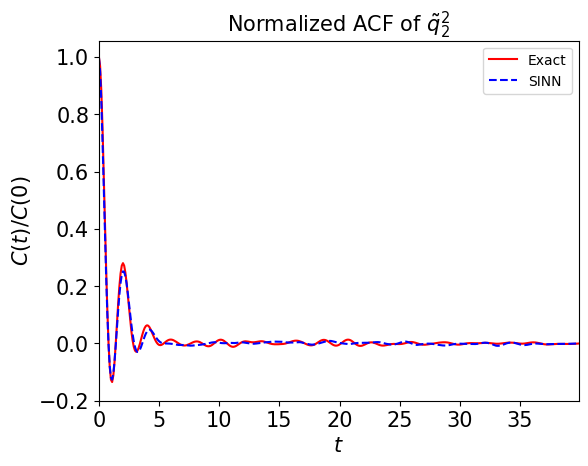

In [36]:
test4(AWmodel_1input_1pair)

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [37]:
def test5(model):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= model.predict_U(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$\tilde{q}_1(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$\tilde{q}_1(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$\tilde{q}_2(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$\tilde{q}_2(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

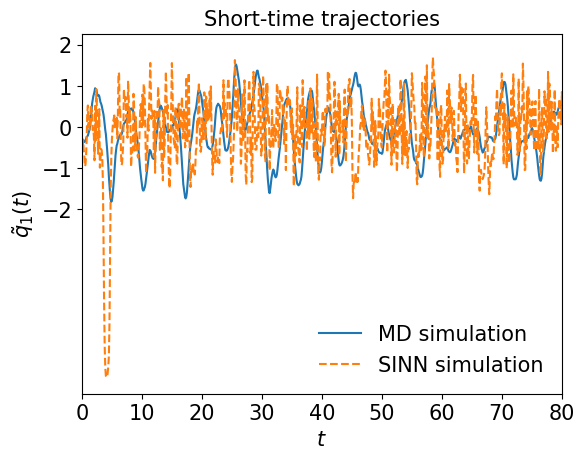

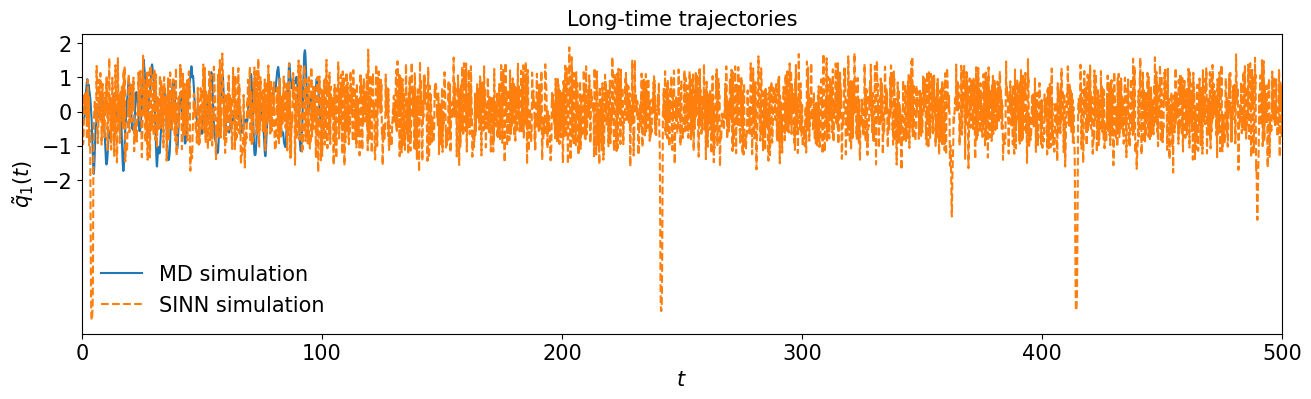

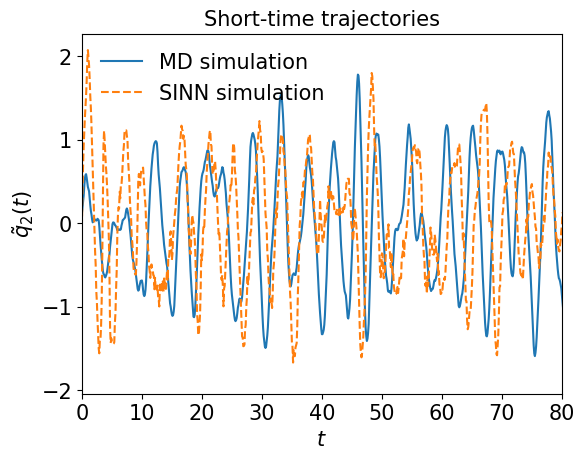

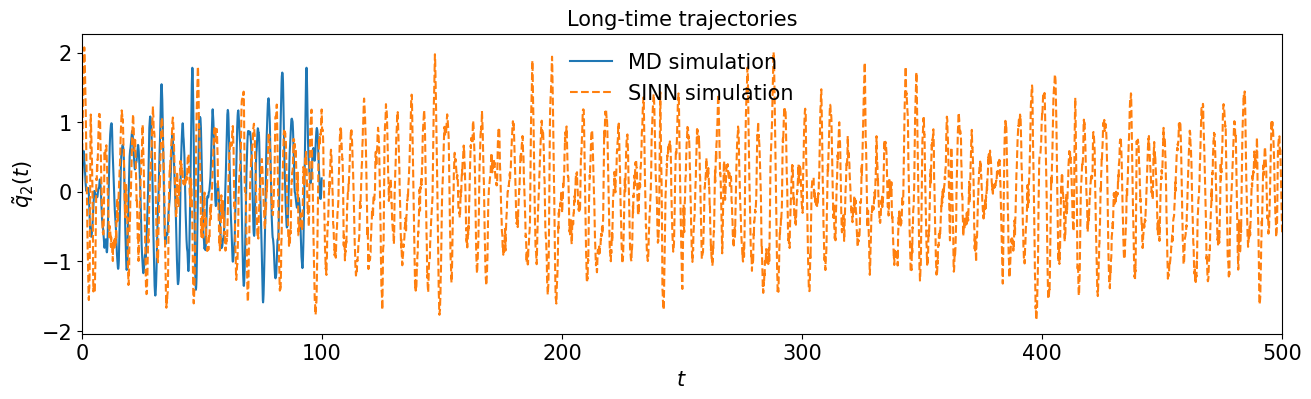

In [38]:
test5(AWmodel_1input_1pair)

# Test 6: comparing scatter plots

In [39]:
def test6(model):
    # Test 6: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.scatter(Traj[:,:,0], Traj[:,:,1])
    plt.xlabel(r'$\tilde{q}_1(t)$',fontsize=15)
    plt.ylabel(r'$\tilde{q}_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.scatter(prediction[:,:,0],prediction[:,:,1])
    plt.xlabel(r'$\tilde{q}_1(t)$',fontsize=15)
    plt.ylabel(r'$\tilde{q}_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

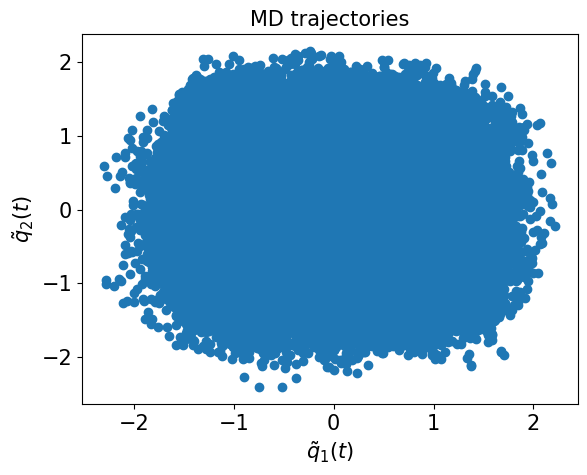

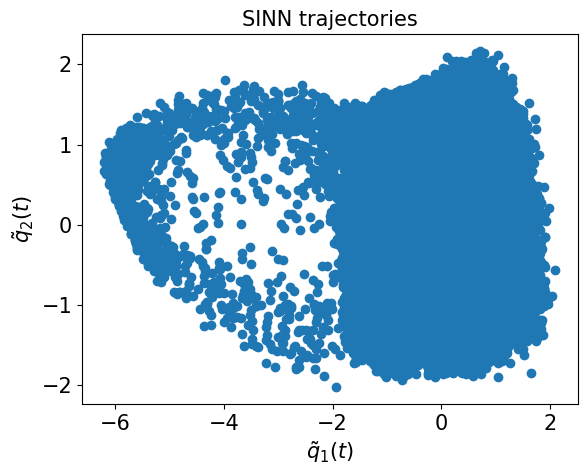

In [40]:
test6(AWmodel_1input_1pair)

In [41]:
def test7(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    rho_data =  StatLoss.gauss_kde2D(target, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde2D(Pred[-sec_length:,:,:].detach(), -5, 5, 400, None).cpu()
    
    fig = plt.figure(0, figsize=(5, 5))
    plt.title("PDF Contours",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
    axs[0]  = fig.gca()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.contour(xx,yy,rho_data.numpy(),colors='r')
    plt.contour(xx,yy,rho_prediction.numpy(),colors='b',linestyles='dashed')

    plt.xlabel(r'$\tilde{q}_1$')
    plt.ylabel(r'$\tilde{q}_2$')

    
    
    fig = plt.figure(1,figsize=(5, 5))
    plt.title("MD trajectories",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_data.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_data.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$\tilde{q}_1$')
    ax.set_ylabel(r'$\tilde{q}_2$')
    
    fig = plt.figure(2,figsize=(5, 5))
    plt.title("SINN output",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_prediction.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_prediction.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$\tilde{q}_1$')
    ax.set_ylabel(r'$\tilde{q}_2$')

    
    
    fig = plt.figure(3,figsize=(5, 5))
    ax = plt.figure().add_subplot(projection='3d')
# X, Y, Z = axes3d.get_test_data(0.05)

# Plot the 3D surface
    ax.plot_surface(xx, yy, rho_data.numpy(), edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph.
    ax.contour(xx, yy, rho_data.numpy(), zdir='z', offset=-0.2, cmap='coolwarm')
    ax.contour(xx, yy, rho_data.numpy(), zdir='x', offset=-5, cmap='coolwarm')
    ax.contour(xx, yy, rho_data.numpy(), zdir='y', offset=5, cmap='coolwarm')

    ax.set(xlim=(-5, 5), ylim=(-5, 5), zlim=(-0.2, 0.3),xlabel=r'$\tilde{q}_1$', ylabel=r'$\tilde{q}_2$', zlabel=r'p($\tilde{q}_1$,$\tilde{q}_2$)')
    ax.set_box_aspect(aspect=None, zoom=0.8)

    
    
    
    

    
    
    
    fig = plt.figure(4,figsize=(5, 5))
    ax = plt.figure().add_subplot(projection='3d')
# X, Y, Z = axes3d.get_test_data(0.05)

# Plot the 3D surface
    ax.plot_surface(xx, yy, rho_prediction.numpy(), edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph.
    ax.contour(xx, yy, rho_prediction.numpy(), zdir='z', offset=-0.2, cmap='coolwarm')
    ax.contour(xx, yy, rho_prediction.numpy(), zdir='x', offset=-5, cmap='coolwarm')
    ax.contour(xx, yy, rho_prediction.numpy(), zdir='y', offset=5, cmap='coolwarm')

    ax.set(xlim=(-5, 5), ylim=(-5, 5), zlim=(-0.2, 0.3),xlabel=r'$\tilde{q}_1$', ylabel=r'$\tilde{q}_2$', zlabel=r'p($\tilde{q}_1$,$\tilde{q}_2$)')
    ax.set_box_aspect(aspect=None, zoom=0.8)

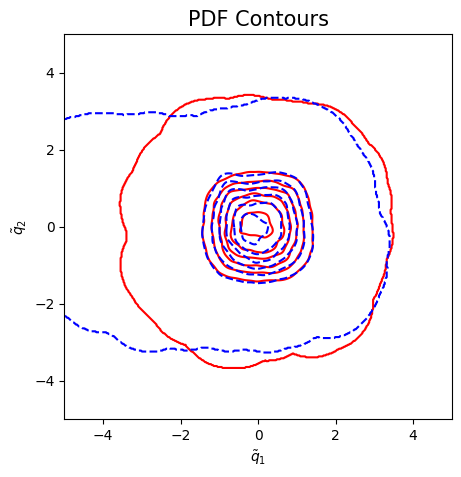

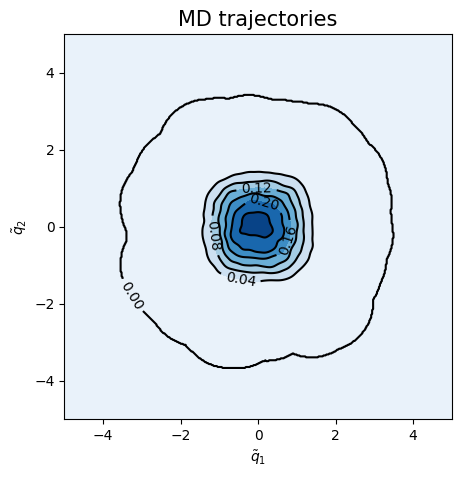

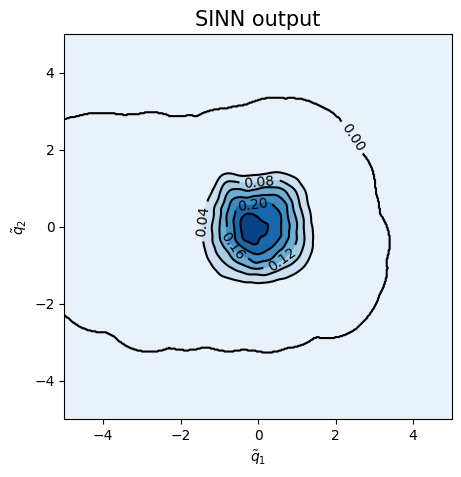

<Figure size 500x500 with 0 Axes>

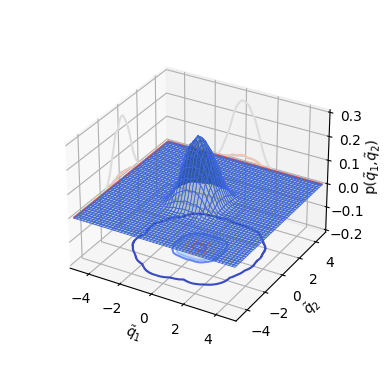

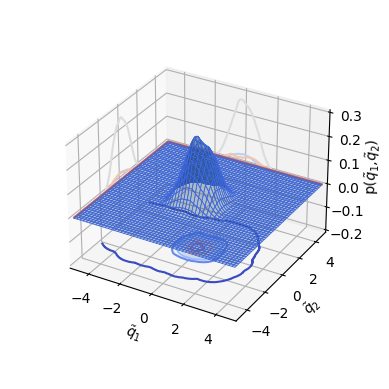

In [42]:
test7(AWmodel_1input_1pair)

# 2. 2 inputs

In [43]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


# Traj = Traj.astype(np.float32) 
# target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
# print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32


In [44]:
### Defining SINN model
net = SINN(2, 10, 2, 2).to(device)
AWmodel_2input_1pair = Model(net=net)

In [45]:
AWmodel_2input_1pair.train()

[0]-th step loss: 0.5119, 0.5103, acf: 0.00959, ccf: 0.00569, pdf: 0.24259, pdf2: 0.25080, acf2: 0.00167
[50]-th step loss: 0.1389, 0.1297, acf: 0.00729, ccf: 0.01402, pdf: 0.06379, pdf2: 0.04234, acf2: 0.00226
[100]-th step loss: 0.0591, 0.0584, acf: 0.00785, ccf: 0.01580, pdf: 0.01562, pdf2: 0.01711, acf2: 0.00205
[150]-th step loss: 0.0447, 0.0444, acf: 0.00642, ccf: 0.01322, pdf: 0.01116, pdf2: 0.01233, acf2: 0.00129
[200]-th step loss: 0.0373, 0.0369, acf: 0.00605, ccf: 0.01142, pdf: 0.00878, pdf2: 0.00948, acf2: 0.00118
[250]-th step loss: 0.0325, 0.0322, acf: 0.00571, ccf: 0.01115, pdf: 0.00688, pdf2: 0.00728, acf2: 0.00123
[300]-th step loss: 0.0290, 0.0288, acf: 0.00455, ccf: 0.01177, pdf: 0.00560, pdf2: 0.00561, acf2: 0.00124
[350]-th step loss: 0.0238, 0.0238, acf: 0.00408, ccf: 0.01078, pdf: 0.00380, pdf2: 0.00421, acf2: 0.00093
[400]-th step loss: 0.0197, 0.0195, acf: 0.00391, ccf: 0.01000, pdf: 0.00211, pdf2: 0.00270, acf2: 0.00075
[450]-th step loss: 0.0171, 0.0173, acf:

[3850]-th step loss: 0.0147, 0.0148, acf: 0.00036, ccf: 0.01425, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00015
[3900]-th step loss: 0.0147, 0.0148, acf: 0.00035, ccf: 0.01425, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00016
[3950]-th step loss: 0.0146, 0.0148, acf: 0.00032, ccf: 0.01426, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00016
[4000]-th step loss: 0.0151, 0.0149, acf: 0.00028, ccf: 0.01445, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00016
[4050]-th step loss: 0.0152, 0.0150, acf: 0.00034, ccf: 0.01446, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00014
[4100]-th step loss: 0.0143, 0.0146, acf: 0.00030, ccf: 0.01408, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00017
[4150]-th step loss: 0.0148, 0.0146, acf: 0.00030, ccf: 0.01414, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00016
[4200]-th step loss: 0.0155, 0.0148, acf: 0.00032, ccf: 0.01431, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00014
[4250]-th step loss: 0.0143, 0.0147, acf: 0.00030, ccf: 0.01422, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00016
[4300]-th step loss: 0.0146,

[7650]-th step loss: 0.0133, 0.0129, acf: 0.00017, ccf: 0.01268, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00007
[7700]-th step loss: 0.0131, 0.0129, acf: 0.00017, ccf: 0.01264, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00006
[7750]-th step loss: 0.0134, 0.0128, acf: 0.00016, ccf: 0.01252, pdf: 0.00002, pdf2: 0.00002, acf2: 0.00007
[7800]-th step loss: 0.0135, 0.0130, acf: 0.00018, ccf: 0.01276, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00006
[7850]-th step loss: 0.0129, 0.0128, acf: 0.00019, ccf: 0.01256, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00006
[7900]-th step loss: 0.0128, 0.0127, acf: 0.00018, ccf: 0.01237, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00006
[7950]-th step loss: 0.0129, 0.0126, acf: 0.00018, ccf: 0.01235, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00006
[8000]-th step loss: 0.0129, 0.0125, acf: 0.00016, ccf: 0.01221, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00006
[8050]-th step loss: 0.0128, 0.0127, acf: 0.00019, ccf: 0.01240, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00006
[8100]-th step loss: 0.0122,

[11450]-th step loss: 0.0091, 0.0092, acf: 0.00019, ccf: 0.00891, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00005
[11500]-th step loss: 0.0081, 0.0081, acf: 0.00011, ccf: 0.00795, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00006
[11550]-th step loss: 0.0081, 0.0079, acf: 0.00011, ccf: 0.00770, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00006
[11600]-th step loss: 0.0079, 0.0075, acf: 0.00011, ccf: 0.00734, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00005
[11650]-th step loss: 0.0080, 0.0076, acf: 0.00012, ccf: 0.00743, pdf: 0.00002, pdf2: 0.00002, acf2: 0.00006
[11700]-th step loss: 0.0074, 0.0075, acf: 0.00011, ccf: 0.00727, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00006
[11750]-th step loss: 0.0072, 0.0072, acf: 0.00013, ccf: 0.00699, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00005
[11800]-th step loss: 0.0072, 0.0073, acf: 0.00011, ccf: 0.00716, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00006
[11850]-th step loss: 0.0076, 0.0076, acf: 0.00013, ccf: 0.00742, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00005
[11900]-th step los

[15250]-th step loss: 0.0072, 0.0068, acf: 0.00514, ccf: 0.00107, pdf: 0.00009, pdf2: 0.00009, acf2: 0.00039
[15300]-th step loss: 0.0016, 0.0040, acf: 0.00174, ccf: 0.00113, pdf: 0.00028, pdf2: 0.00032, acf2: 0.00052
[15350]-th step loss: 0.0253, 0.0230, acf: 0.00437, ccf: 0.00616, pdf: 0.00672, pdf2: 0.00463, acf2: 0.00111
[15400]-th step loss: 0.0130, 0.0130, acf: 0.00342, ccf: 0.00292, pdf: 0.00318, pdf2: 0.00242, acf2: 0.00106
[15450]-th step loss: 0.0088, 0.0086, acf: 0.00306, ccf: 0.00102, pdf: 0.00175, pdf2: 0.00170, acf2: 0.00106
[15500]-th step loss: 0.0065, 0.0066, acf: 0.00249, ccf: 0.00021, pdf: 0.00125, pdf2: 0.00163, acf2: 0.00097
[15550]-th step loss: 0.0059, 0.0059, acf: 0.00202, ccf: 0.00011, pdf: 0.00122, pdf2: 0.00163, acf2: 0.00095
[15600]-th step loss: 0.0052, 0.0052, acf: 0.00209, ccf: 0.00009, pdf: 0.00088, pdf2: 0.00125, acf2: 0.00089
[15650]-th step loss: 0.0045, 0.0046, acf: 0.00206, ccf: 0.00007, pdf: 0.00063, pdf2: 0.00097, acf2: 0.00084
[15700]-th step los

[19050]-th step loss: 0.0004, 0.0004, acf: 0.00022, ccf: 0.00005, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00006
[19100]-th step loss: 0.0004, 0.0004, acf: 0.00023, ccf: 0.00006, pdf: 0.00002, pdf2: 0.00002, acf2: 0.00006
[19150]-th step loss: 0.0004, 0.0003, acf: 0.00021, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00006
[19200]-th step loss: 0.0004, 0.0004, acf: 0.00020, ccf: 0.00006, pdf: 0.00002, pdf2: 0.00002, acf2: 0.00006
[19250]-th step loss: 0.0005, 0.0004, acf: 0.00020, ccf: 0.00008, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00006
[19300]-th step loss: 0.0004, 0.0003, acf: 0.00021, ccf: 0.00006, pdf: 0.00001, pdf2: 0.00002, acf2: 0.00006
[19350]-th step loss: 0.0004, 0.0004, acf: 0.00021, ccf: 0.00007, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00006
[19400]-th step loss: 0.0004, 0.0005, acf: 0.00024, ccf: 0.00014, pdf: 0.00002, pdf2: 0.00003, acf2: 0.00007
[19450]-th step loss: 0.0004, 0.0003, acf: 0.00020, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00005
[19500]-th step los

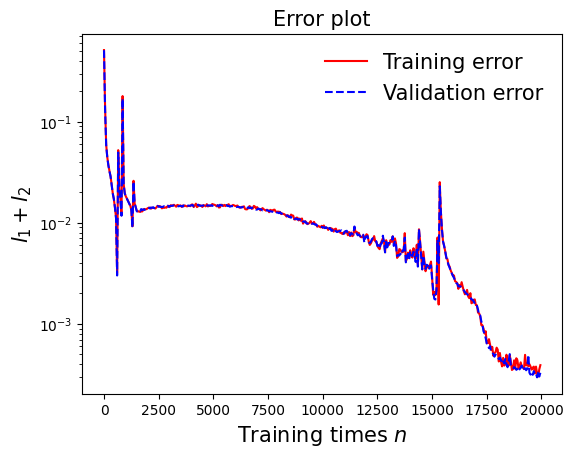

In [46]:
draw_loss(AWmodel_2input_1pair)

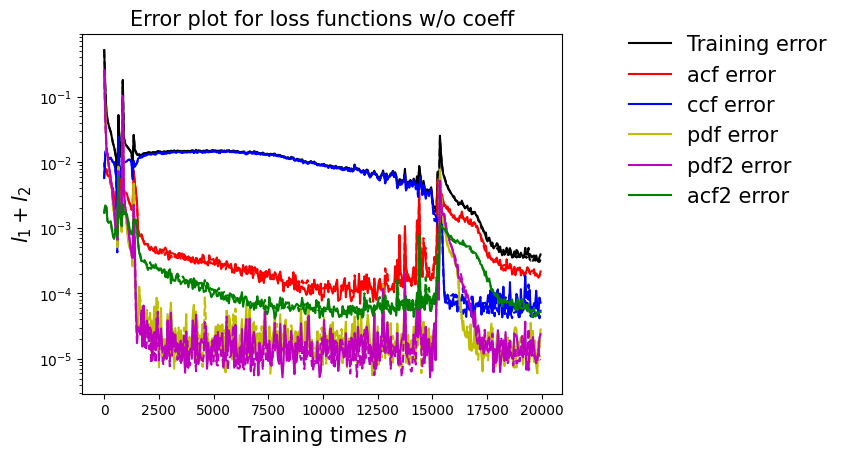

In [47]:
draw_errors(AWmodel_2input_1pair)

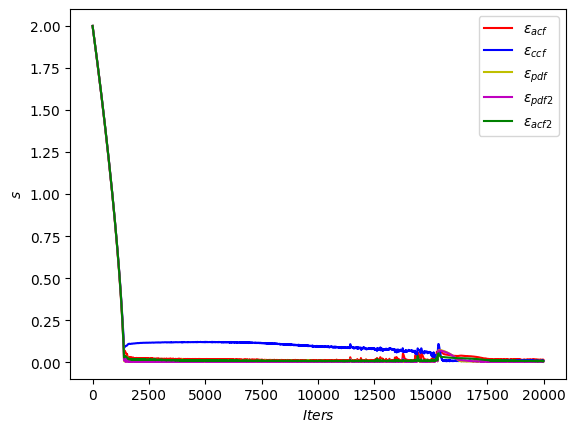

In [48]:
draw_adaptive_w(AWmodel_2input_1pair)

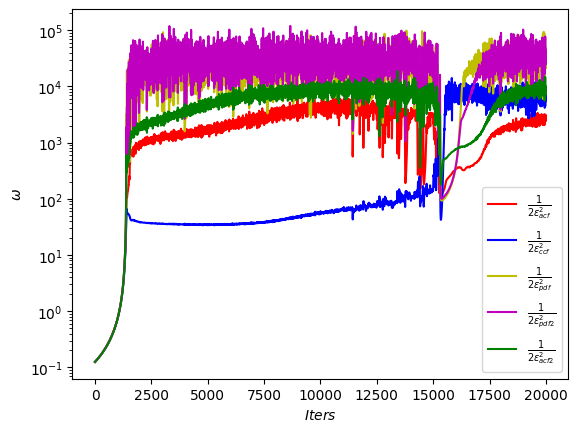

In [49]:
draw_epoch_w(AWmodel_2input_1pair)

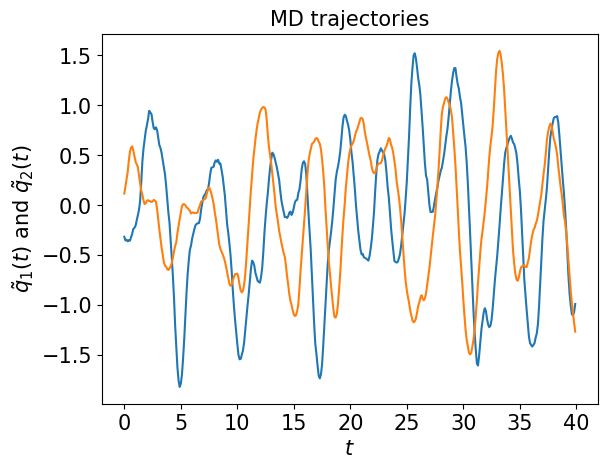

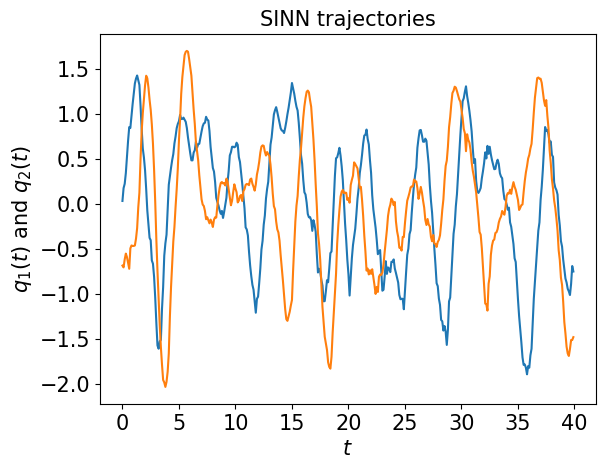

In [50]:
test1(AWmodel_2input_1pair)

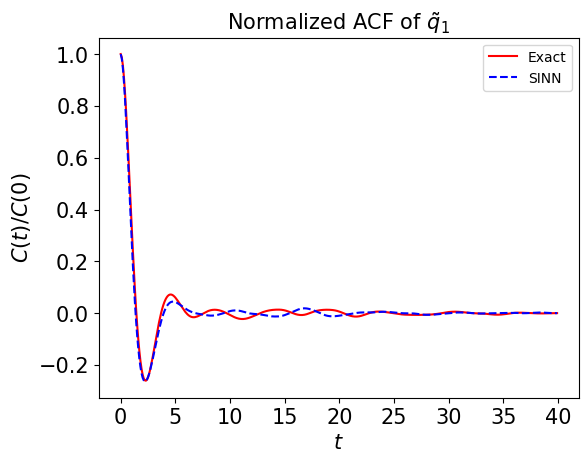

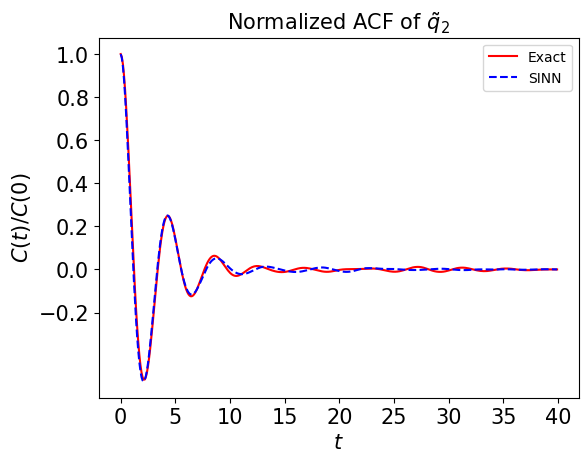

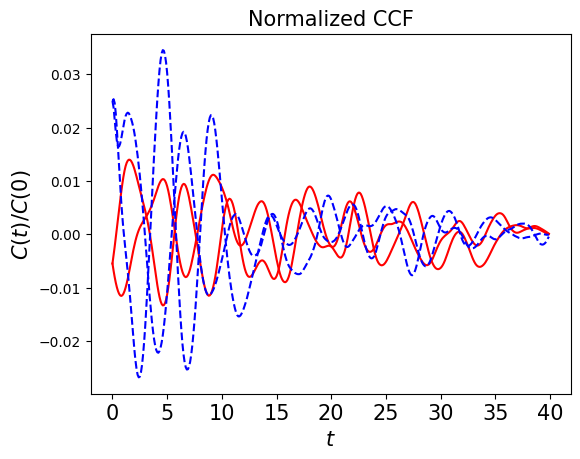

In [51]:
test2(AWmodel_2input_1pair)

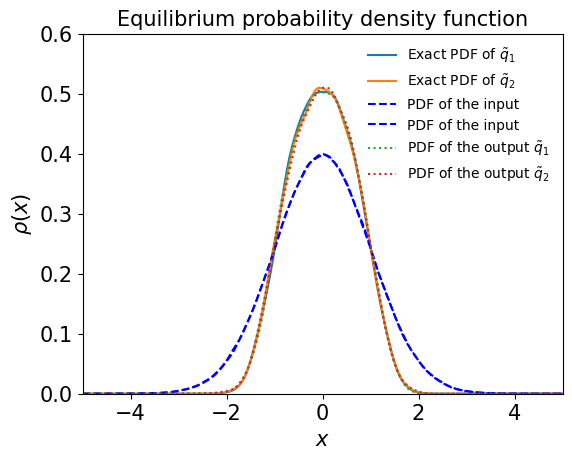

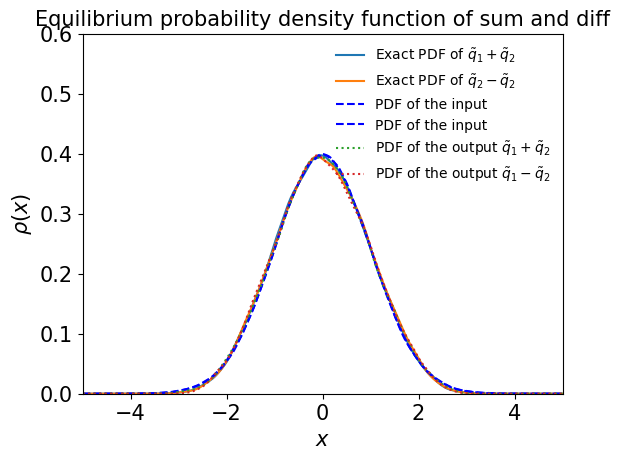

In [52]:
test3(AWmodel_2input_1pair)

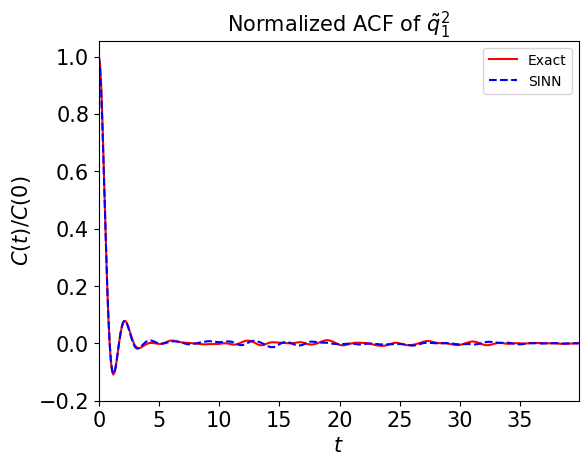

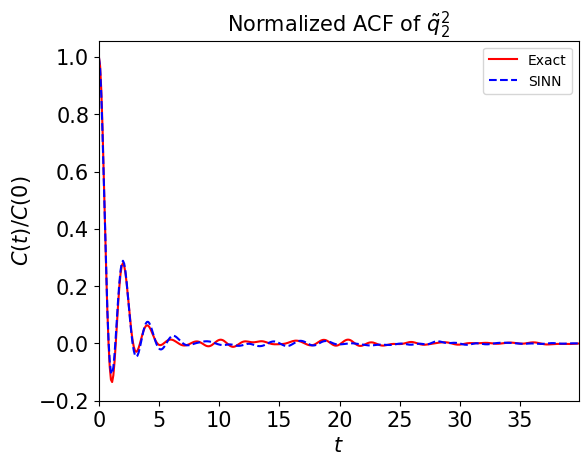

In [53]:
test4(AWmodel_2input_1pair)

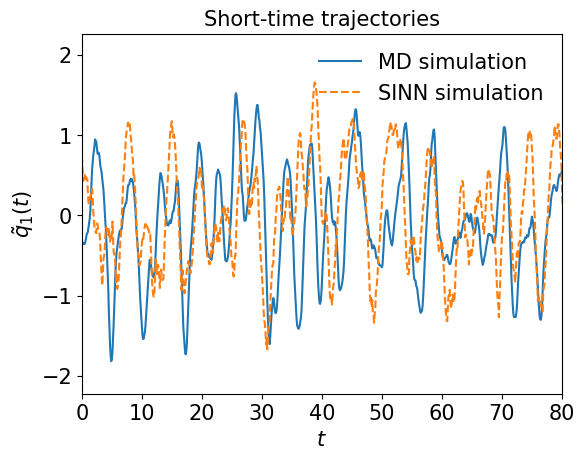

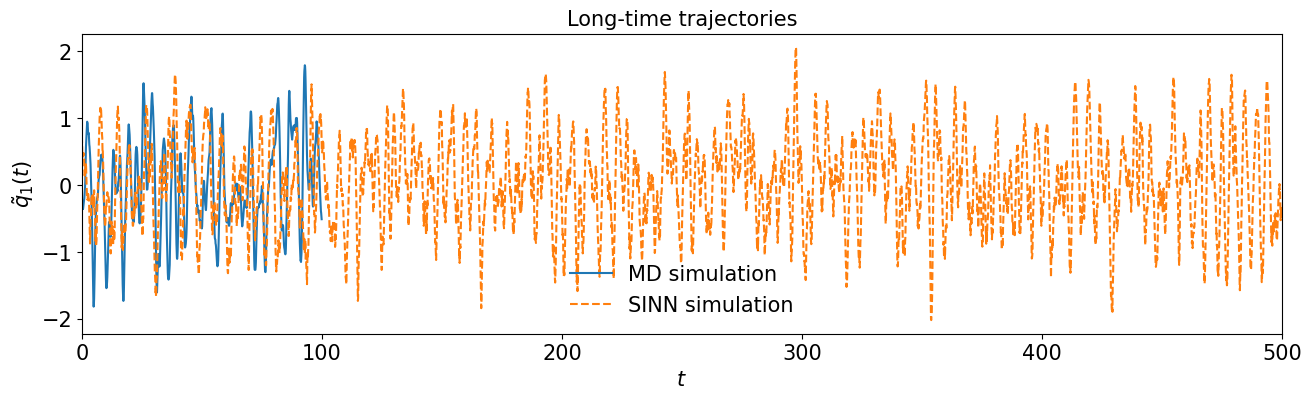

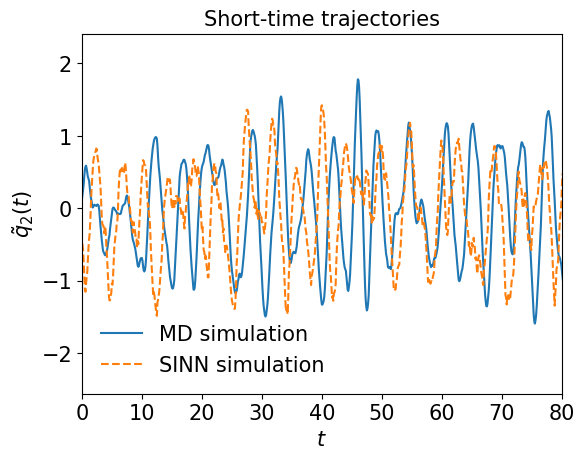

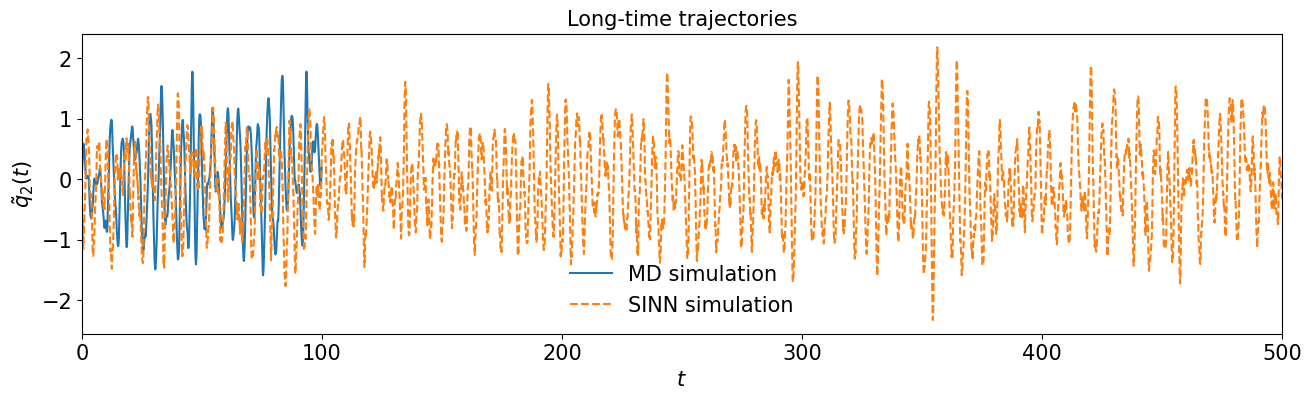

In [54]:
test5(AWmodel_2input_1pair)

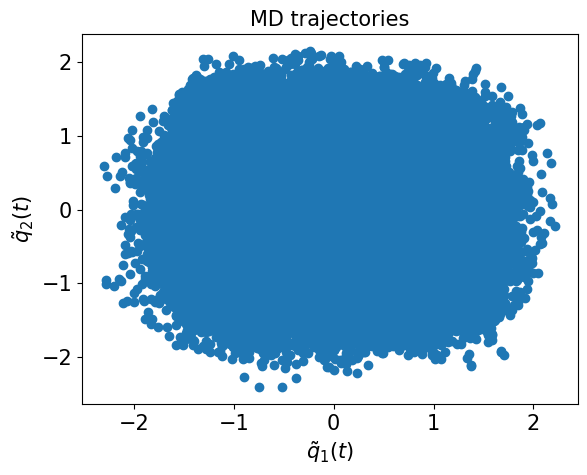

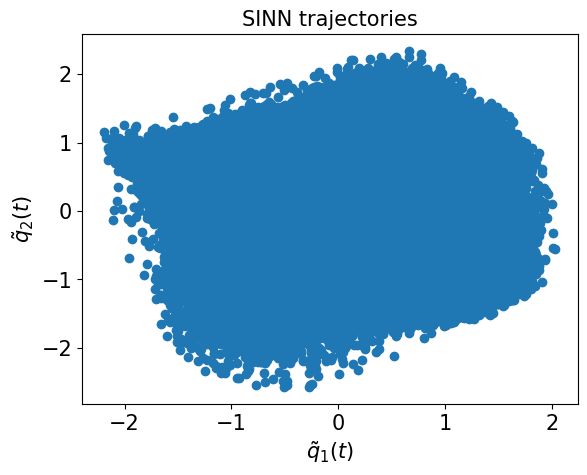

In [55]:
test6(AWmodel_2input_1pair)

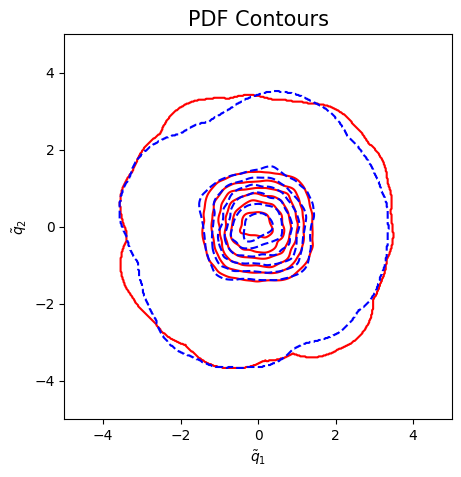

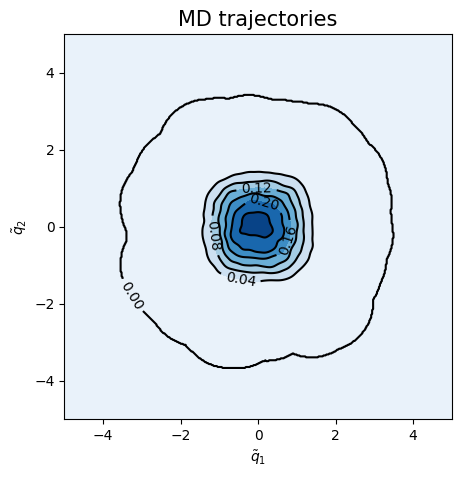

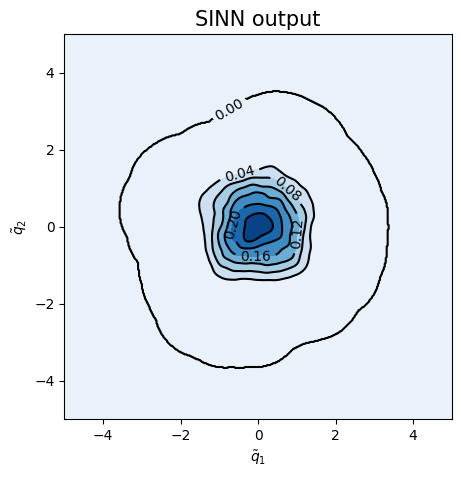

<Figure size 500x500 with 0 Axes>

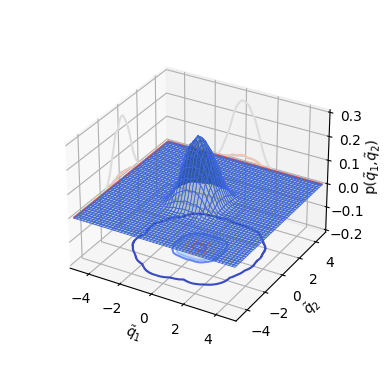

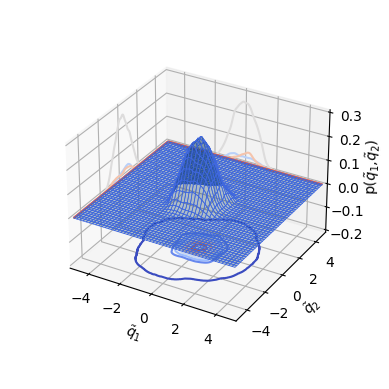

In [56]:
test7(AWmodel_2input_1pair)

In [58]:
torch.save(AWmodel_2input_1pair.net.state_dict(), "/home/zxu64/GIT/Multidimensional-SINN/AWmodel_2input_1pair.pth")